In [1]:
!pip install albumentations timm torchsummary

In [2]:
import json
import os
import shutil
from PIL import Image
from tqdm import tqdm

data_root = '/content/drive/Othercomputers/내 Mac/Chapter 31 ~ Chapter 45/chapter37'

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'val')
train_dataset = datasets.ImageFolder(root=train_dir)
val_dataset = datasets.ImageFolder(root=val_dir)

In [4]:
data = train_dataset[0]

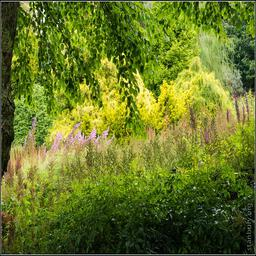

In [5]:
data[0]

In [6]:
data[1]

0

In [7]:
print(f'학습 데이터 개수 : {len(train_dataset)}')
print(f'검증 데이터 개수 : {len(val_dataset)}')

학습 데이터 개수 : 14128
검증 데이터 개수 : 1612


In [8]:
train_dataset.classes

['astilbe',
 'bellflower',
 'black_eyed_susan',
 'calendula',
 'california_poppy',
 'carnation',
 'common_daisy',
 'coreopsis',
 'daffodil',
 'dandelion',
 'iris',
 'magnolia',
 'rose',
 'sunflower',
 'tulip',
 'water_lily']

In [9]:
from collections import Counter

class_counts = Counter(train_dataset.targets)
class_names = train_dataset.classes

for idx, count in class_counts.items():
    print(f"Class: {class_names[idx]}, Count: {count}")

Class: astilbe, Count: 664
Class: bellflower, Count: 792
Class: black_eyed_susan, Count: 903
Class: calendula, Count: 864
Class: california_poppy, Count: 911
Class: carnation, Count: 845
Class: common_daisy, Count: 874
Class: coreopsis, Count: 925
Class: daffodil, Count: 880
Class: dandelion, Count: 945
Class: iris, Count: 943
Class: magnolia, Count: 941
Class: rose, Count: 901
Class: sunflower, Count: 929
Class: tulip, Count: 949
Class: water_lily, Count: 862


In [10]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


def draw_images(images, classes):
    fig, axs = plt.subplots(4, 2, figsize=(12, 6))

    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i])
        ax.set_title(classes[i])

    plt.tight_layout()
    plt.show()

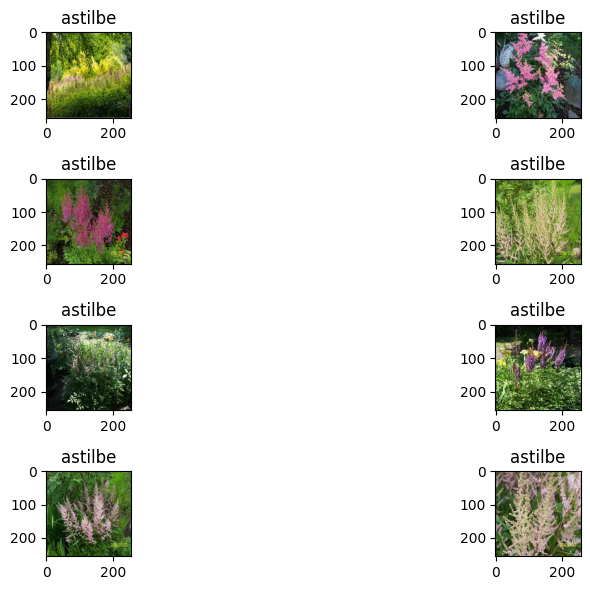

In [11]:
from PIL import Image
import numpy as np


sample_images = []
sample_classes = []
sample_cnt = 0
max_cnt = 8
for image, target in train_dataset:
    sample_classes.append(class_names[target])
    sample_images.append(image)
    sample_cnt += 1
    if sample_cnt == max_cnt:
        break

draw_images(sample_images, sample_classes)

In [12]:
hyper_params = {
    'num_epochs': 10,
    'lr': 0.0001,
    'image_size': 224,
    'train_batch_size': 32,
    'val_batch_size': 16,
    'print_preq': 0.1
}


In [13]:
train_transform = transforms.Compose([
    transforms.Resize((hyper_params['image_size'], hyper_params['image_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

val_transform = transforms.Compose([
    transforms.Resize((hyper_params['image_size'], hyper_params['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hyper_params['train_batch_size'],
                                               num_workers=4, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hyper_params['val_batch_size'],
                                             num_workers=4, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


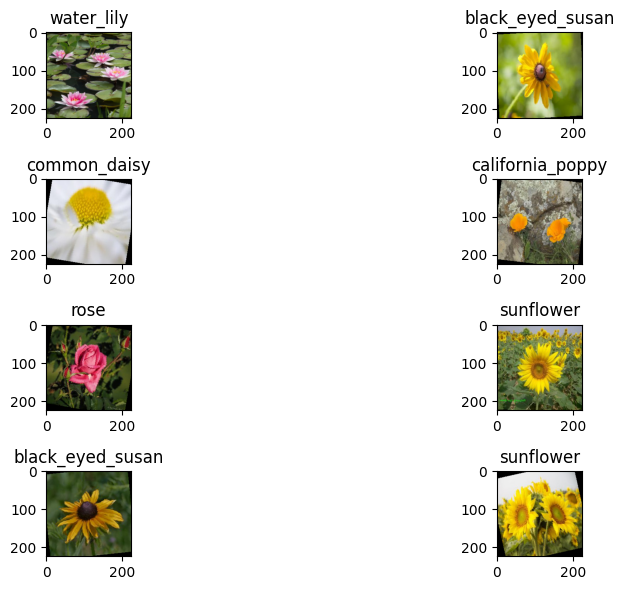

In [14]:
import torch
from torchvision.transforms.functional import to_pil_image

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).reshape(-1, 1, 1)
    std = torch.tensor(std).reshape(-1, 1, 1)

    tensor = tensor * std + mean

    tensor = torch.clamp(tensor, 0, 1)

    return tensor

def tensor_to_pil(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):

    tensor = denormalize(tensor, mean, std)

    pil_image = to_pil_image(tensor)

    return pil_image


transformed_images = []
targets = []

max_cnt = 8
sample_images = []
sample_classes = []
for idx, (images, targets) in enumerate(train_dataloader):
    if idx == max_cnt:
        break
    image = images[0]
    target = targets[0]

    sample_images.append(tensor_to_pil(image))
    sample_classes.append(class_names[int(target)])

draw_images(sample_images, sample_classes)

### 다른 일반 모델과 비교

In [15]:
import timm

timm.list_models("mobile*")[:20]

['mobilenet_edgetpu_100',
 'mobilenet_edgetpu_v2_l',
 'mobilenet_edgetpu_v2_m',
 'mobilenet_edgetpu_v2_s',
 'mobilenet_edgetpu_v2_xs',
 'mobilenetv1_100',
 'mobilenetv1_100h',
 'mobilenetv1_125',
 'mobilenetv2_035',
 'mobilenetv2_050',
 'mobilenetv2_075',
 'mobilenetv2_100',
 'mobilenetv2_110d',
 'mobilenetv2_120d',
 'mobilenetv2_140',
 'mobilenetv3_large_075',
 'mobilenetv3_large_100',
 'mobilenetv3_large_150d',
 'mobilenetv3_rw',
 'mobilenetv3_small_050']

In [16]:
import torch
import torch.nn as nn
import timm

def get_model(model_name, num_classes, pretrinaed=True, weight_path='', device='cpu'):
    model = timm.create_model(model_name,
                              pretrained=pretrinaed,
                              num_classes=num_classes)
    if weight_path:
        model.load_state_dict(torch.load(weight_path, map_location='cpu'))
    model.to(device)

    return model

In [17]:
model = get_model(model_name='mobilenetv3_small_075', num_classes=len(class_names), device='cpu')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/8.23M [00:00<?, ?B/s]

In [18]:
model

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): ReLU(inplace=True)
          (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (gate): Hardsigmoid()
        )
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): B

In [19]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
          Identity-2         [-1, 16, 112, 112]               0
         Hardswish-3         [-1, 16, 112, 112]               0
    BatchNormAct2d-4         [-1, 16, 112, 112]              32
            Conv2d-5           [-1, 16, 56, 56]             144
          Identity-6           [-1, 16, 56, 56]               0
              ReLU-7           [-1, 16, 56, 56]               0
    BatchNormAct2d-8           [-1, 16, 56, 56]              32
          Identity-9           [-1, 16, 56, 56]               0
           Conv2d-10              [-1, 8, 1, 1]             136
             ReLU-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 16, 1, 1]             144
      Hardsigmoid-13             [-1, 16, 1, 1]               0
    SqueezeExcite-14           [-1, 16,

In [20]:
from torchvision import models

sample_model = models.resnet18(num_classes=len(class_names))
summary(sample_model, input_size=(3, 224, 224), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [21]:
import time

device = 'cpu'

effi_model = get_model('efficientnet_b0', num_classes=len(class_names), pretrinaed=False).eval().to(device)
resnet_model = get_model('resnet18', num_classes=len(class_names), pretrinaed=False).eval().to(device)
vgg_model = get_model('vgg16', num_classes=len(class_names), pretrinaed=False).eval().to(device)
mobilenet_model = get_model('mobilenetv3_small_075', num_classes=len(class_names), pretrinaed=False).eval().to(device)

model_list = [
    ('efficientnet_b0', effi_model),
    ('resnet18', resnet_model),
    ('vgg16', vgg_model),
    ('mobilenetV3', mobilenet_model)
]

sample_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    for model_name, model in model_list:
        model(sample_input)
        model(sample_input)

        st_time = time.time()
        model(sample_input)
        end_time = time.time()

        print(f"{model_name} inf times : {end_time - st_time}")

efficientnet_b0 inf times : 0.08701419830322266
resnet18 inf times : 0.13898587226867676
vgg16 inf times : 0.7080390453338623
mobilenetV3 inf times : 0.01047205924987793


In [23]:
!pip install wandb

In [24]:
wandb login

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [25]:
import wandb

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import wandb
import os

wandb.init(project="Model_Optimization", config=hyper_params)
config = wandb.config

model = get_model('mobilenetv3_small_075', num_classes=len(class_names))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = config['num_epochs']
model_save_dir = '/content/drive/Othercomputers/내 Mac/Chapter 31 ~ Chapter 45/part2_chapter37_train_results'
os.makedirs(model_save_dir, exist_ok=True)

best_acc = 0.0

def calculate_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    print_cnt = int(len(train_dataloader) * config['print_preq'])

    for idx, (images, targets) in enumerate(train_dataloader):
        images, targets = images.to(device), targets.to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()

        if idx % print_cnt == 0:
            avg_loss = running_loss / print_cnt
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Iter [{idx}/{len(train_dataloader)}] "
                  f"Loss: {avg_loss:.4f}")
            wandb.log({"Train Loss (Batch)": avg_loss})
            running_loss = 0.0

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
    wandb.log({"Train Loss (Epoch)": avg_epoch_loss})

    accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for images, targets in val_dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            accuracy += calculate_accuracy(outputs, targets)
    acc = accuracy / len(val_dataloader)
    print(f"Accuracy: {acc*100:.2f}%")
    wandb.log({"Validation Accuracy": acc.item() * 100})

    if acc > best_acc:
        model_save_path = os.path.join(model_save_dir, f'best_model.pth')
        torch.save(model.state_dict(), model_save_path)
        best_acc = acc
        wandb.log({"Best Accuracy": best_acc.item() * 100})

wandb.finish()


wandb: Currently logged in as: datafullstack0514 (datafullstack0514-person). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10], Iter [0/442] Loss: 0.0724
Epoch [1/10], Iter [44/442] Loss: 3.1463
Epoch [1/10], Iter [88/442] Loss: 2.5986
Epoch [1/10], Iter [132/442] Loss: 2.1914
Epoch [1/10], Iter [176/442] Loss: 1.9440
Epoch [1/10], Iter [220/442] Loss: 1.6710
Epoch [1/10], Iter [264/442] Loss: 1.3964
Epoch [1/10], Iter [308/442] Loss: 1.2273
Epoch [1/10], Iter [352/442] Loss: 1.1153
Epoch [1/10], Iter [396/442] Loss: 1.0648
Epoch [1/10], Iter [440/442] Loss: 0.8725
Epoch [1/10], Loss: 1.7237
Accuracy: 73.89%
Epoch [2/10], Iter [0/442] Loss: 0.0239
Epoch [2/10], Iter [44/442] Loss: 0.8299
Epoch [2/10], Iter [88/442] Loss: 0.7645
Epoch [2/10], Iter [132/442] Loss: 0.7083
Epoch [2/10], Iter [176/442] Loss: 0.6811
Epoch [2/10], Iter [220/442] Loss: 0.6924
Epoch [2/10], Iter [264/442] Loss: 0.6522
Epoch [2/10], Iter [308/442] Loss: 0.6318
Epoch [2/10], Iter [352/442] Loss: 0.6616
Epoch [2/10], Iter [396/442] Loss: 0.5799
Epoch [2/10], Iter [440/442] Loss: 0.5641
Epoch [2/10], Loss: 0.6773
Accuracy: 83.

Best Accuracy,▁▅▆▇▇██
Train Loss (Batch),█▇▅▅▄▃▃▃▃▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Train Loss (Epoch),█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▅▆▇▇█▇███
Best Accuracy,92.14109
Train Loss (Batch),0.18748
Train Loss (Epoch),0.20106
Validation Accuracy,91.95544


In [22]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.metrics import f1_score

# def calculate_accuracy(y_pred, y_true):
#     _, predicted = torch.max(y_pred, 1)
#     correct = (predicted == y_true).float()
#     accuracy = correct.sum() / len(correct)
#     return accuracy

# model = get_model('mobilenetv3_small_075', num_classes=len(class_names))

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=hyper_params['lr'])

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# num_epochs = hyper_params['num_epochs']
# model_save_dir = './part2_chapter37_train_results'
# os.makedirs(model_save_dir, exist_ok=True)

# best_acc = 0.0
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     epoch_loss = 0.0
#     print_cnt = int(len(train_dataloader) * hyper_params['print_preq'])

#     for idx, (images, targets) in enumerate(train_dataloader):
#         images, targets = images.to(device), targets.to(device)

#         outputs = model(images)
#         loss = criterion(outputs, targets)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         epoch_loss += loss.item()

#         if idx % print_cnt == 0:
#             print(f"Epoch [{epoch+1}/{num_epochs}], "
#                   f"Iter [{idx}/{len(train_dataloader)}] "
#                   f"Loss: {running_loss/print_cnt:.4f}")
#             running_loss = 0.0


#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}")

#     accuracy = 0.0
#     model.eval()
#     with torch.no_grad():
#         for images, targets in val_dataloader:
#             images, targets = images.to(device), targets.to(device)
#             outputs = model(images)
#             accuracy += calculate_accuracy(outputs, targets)
#     acc = accuracy / len(val_dataloader)
#     print(f"Accuracy: {acc*100:.2f}%")

#     if acc > best_acc:
#         model_save_path = os.path.join(model_save_dir, f'best_model.pth')
#         torch.save(model.state_dict(), model_save_path)
#         best_acc = acc

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
del model

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import wandb

wandb.init(project="Model_Optimization", config=hyper_params)
config = wandb.config

model = get_model(model_name='efficientnet_b1', num_classes=len(class_names), device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

num_epochs = config['num_epochs']
model_save_dir = '/content/drive/Othercomputers/내 Mac/Chapter 31 ~ Chapter 45/part2_chapter37_effi_train_results'
os.makedirs(model_save_dir, exist_ok=True)

best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    print_cnt = int(len(train_dataloader) * config['print_preq'])

    for idx, (images, targets) in enumerate(train_dataloader):
        images, targets = images.to(device), targets.to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()

        if idx % print_cnt == 0:
            avg_loss = running_loss / print_cnt
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Iter [{idx}/{len(train_dataloader)}] "
                  f"Loss: {avg_loss:.4f}")
            wandb.log({"Train Loss (Batch)": avg_loss})
            running_loss = 0.0

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
    wandb.log({"Train Loss (Epoch)": avg_epoch_loss})

    accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for images, targets in val_dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            accuracy += calculate_accuracy(outputs, targets)
    acc = accuracy / len(val_dataloader)
    print(f"Accuracy: {acc*100:.2f}%")
    wandb.log({"Validation Accuracy": acc.item() * 100})

    if acc > best_acc:
        model_save_path = os.path.join(model_save_dir, f'best_model.pth')
        torch.save(model.state_dict(), model_save_path)
        best_acc = acc
        wandb.log({"Best Accuracy": best_acc.item() * 100})

wandb.finish()

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

Epoch [1/10], Iter [0/442] Loss: 0.0928
Epoch [1/10], Iter [44/442] Loss: 1.7484
Epoch [1/10], Iter [88/442] Loss: 0.6600
Epoch [1/10], Iter [132/442] Loss: 0.5076
Epoch [1/10], Iter [176/442] Loss: 0.5012
Epoch [1/10], Iter [220/442] Loss: 0.3944
Epoch [1/10], Iter [264/442] Loss: 0.4608
Epoch [1/10], Iter [308/442] Loss: 0.3072
Epoch [1/10], Iter [352/442] Loss: 0.3179
Epoch [1/10], Iter [396/442] Loss: 0.3062
Epoch [1/10], Iter [440/442] Loss: 0.2876
Epoch [1/10], Loss: 0.5572
Accuracy: 92.95%
Epoch [2/10], Iter [0/442] Loss: 0.0061
Epoch [2/10], Iter [44/442] Loss: 0.1736
Epoch [2/10], Iter [88/442] Loss: 0.1489
Epoch [2/10], Iter [132/442] Loss: 0.1463
Epoch [2/10], Iter [176/442] Loss: 0.1776
Epoch [2/10], Iter [220/442] Loss: 0.1674
Epoch [2/10], Iter [264/442] Loss: 0.1491
Epoch [2/10], Iter [308/442] Loss: 0.1748
Epoch [2/10], Iter [352/442] Loss: 0.2087
Epoch [2/10], Iter [396/442] Loss: 0.2083
Epoch [2/10], Iter [440/442] Loss: 0.1948
Epoch [2/10], Loss: 0.1756
Accuracy: 93.

Best Accuracy,▁▃▅▇█
Train Loss (Batch),▁█▃▃▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss (Epoch),█▃▂▂▁▂▁▁▁▁
Validation Accuracy,▁▄▁▅▄▃▇█▆▅
Best Accuracy,95.42079
Train Loss (Batch),0.06618
Train Loss (Epoch),0.0798
Validation Accuracy,94.32756


In [ ]:
# model = get_model(model_name='efficientnet_b1', num_classes=len(class_names), device=device)

# hyper_params = {
#     'num_epochs': 5,
#     'lr': 0.0001,
#     'image_size': 224,
#     'train_batch_size': 16,
#     'val_batch_size': 16,
#     'print_preq': 0.1
# }


# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=hyper_params['lr'])

# num_epochs = hyper_params['num_epochs']
# model_save_dir = '/content/drive/Othercomputers/내 Mac/Chapter 31 ~ Chapter 45/part2_chapter37_effi_train_results'
# os.makedirs(model_save_dir, exist_ok=True)

# best_acc = 0.0
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     epoch_loss = 0.0
#     print_cnt = int(len(train_dataloader) * hyper_params['print_preq'])

#     for idx, (images, targets) in enumerate(train_dataloader):
#         images, targets = images.to(device), targets.to(device)

#         # 순전파
#         outputs = model(images)
#         loss = criterion(outputs, targets)

#         # 역전파 및 가중치 업데이트
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         epoch_loss += loss.item()

#         if idx % print_cnt == 0:
#             print(f"Epoch [{epoch+1}/{num_epochs}], "
#                   f"Iter [{idx}/{len(train_dataloader)}] "
#                   f"Loss: {running_loss/print_cnt:.4f}")
#             running_loss = 0.0



#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}")

#     accuracy = 0.0
#     model.eval()
#     with torch.no_grad():
#         for images, targets in val_dataloader:
#             images, targets = images.to(device), targets.to(device)
#             outputs = model(images)
#             accuracy += calculate_accuracy(outputs, targets)
#     acc = accuracy / len(val_dataloader)
#     print(f"Accuracy: {acc*100:.2f}%")

#     if acc > best_acc:
#         model_save_path = os.path.join(model_save_dir, f'best_model.pth')
#         torch.save(model.state_dict(), model_save_path)
#         best_acc = acc

In [28]:
model_list = [
    (
        'MobilenetV3',
        get_model(model_name='mobilenetv3_small_075',
                  num_classes=len(class_names),
                  weight_path='/content/drive/Othercomputers/내 Mac/Chapter 31 ~ Chapter 45/part2_chapter37_train_results/best_model.pth',
                  device=device),
    ),
    (
        'Efficientnet_b1',
        get_model(model_name='efficientnet_b1',
                  num_classes=len(class_names),
                  weight_path='/content/drive/Othercomputers/내 Mac/Chapter 31 ~ Chapter 45/part2_chapter37_effi_train_results/best_model.pth',
                  device=device)
    )
]
for model_name, model in model_list:
    model = model.eval().to(device)
    accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for images, targets in val_dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            accuracy += calculate_accuracy(outputs, targets)
    acc = accuracy / len(val_dataloader)
    print(f"{model_name} ACC : {acc}")

<ipython-input-16-c544589c8db0>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path, map_location='cpu'))


MobilenetV3 ACC : 0.921410858631134
Efficientnet_b1 ACC : 0.9542078971862793


In [29]:
import torch
from torchvision.transforms.functional import to_pil_image

def denormalize(tensor, mean, std):

    mean = torch.tensor(mean).reshape(-1, 1, 1)
    std = torch.tensor(std).reshape(-1, 1, 1)

    tensor = tensor * std + mean

    tensor = torch.clamp(tensor, 0, 1)

    return tensor

def tensor_to_pil(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):

    tensor = denormalize(tensor, mean, std)

    pil_image = to_pil_image(tensor)

    return pil_image

In [30]:
val_transform = transforms.Compose([
    transforms.Resize((hyper_params['image_size'], hyper_params['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8,
                                             num_workers=4, shuffle=True)

In [32]:
import torch.nn.functional as F

## shufflnet model
# model = get_model('mobilenetv3_small_075', num_classes=len(class_names))
# weight_path = 'part2_chapter37_train_results/best_model.pth'
# model.load_state_dict(torch.load(weight_path, map_location='cpu'))
# model.eval()
class_list = val_dataset.classes
model = timm.create_model(model_name='efficientnet_b1', num_classes=len(class_list)).to(device)
weight_path = '/content/drive/Othercomputers/내 Mac/Chapter 31 ~ Chapter 45/part2_chapter37_effi_train_results//best_model.pth'
model.load_state_dict(torch.load(weight_path, map_location='cpu'))
model.eval()

max_cnt = 0
pred_list = []
top3_idx_list = []
top3_value_list = []
image_list = []
with torch.no_grad():
    for images, targets in val_dataloader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)

        for image in images:
            image_list.append(tensor_to_pil(image.cpu()))
        pred = F.softmax(outputs, dim=1)

        top3_values, top3_indices = torch.topk(pred, 3, dim=1)
        top3_value_list.extend(top3_values.cpu().numpy().tolist())
        top3_idx_list.extend(top3_indices.cpu().numpy().tolist())
        break

<ipython-input-32-02f66472d5f0>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path, map_location='cpu'))


In [33]:
top3_value_list


[[1.0, 1.9679766496971673e-11, 6.76431024908275e-13],
 [0.9965963959693909, 0.003192514879629016, 0.0001630574552109465],
 [0.9521174430847168, 0.04597673565149307, 0.0014094066573306918],
 [0.9997572302818298, 0.00021057868434581906, 1.9592547687352635e-05],
 [1.0, 9.577271701394219e-13, 1.231470708826926e-13],
 [0.9999994039535522, 2.815019115587347e-07, 2.2587668979667797e-07],
 [0.9999831914901733, 1.6277204849757254e-05, 5.172474857317866e-07],
 [1.0, 1.0222018544114864e-12, 3.819989154894642e-16]]

In [34]:
top3_idx_list

[[12, 13, 1],
 [3, 14, 13],
 [5, 4, 12],
 [15, 11, 0],
 [8, 9, 13],
 [4, 5, 9],
 [2, 7, 13],
 [9, 3, 5]]

In [35]:
top1_class_list = []

for top3_idxs, top3_values in zip(top3_idx_list, top3_value_list):
    flag=True
    for idx, value in zip(top3_idxs, top3_values):
        print(f"Class {class_list[idx]} : {value*100:.2f}%")
        if flag:
            top1_class_list.append(class_list[idx])
            flag=False
    print()

Class rose : 100.00%
Class sunflower : 0.00%
Class bellflower : 0.00%

Class calendula : 99.66%
Class tulip : 0.32%
Class sunflower : 0.02%

Class carnation : 95.21%
Class california_poppy : 4.60%
Class rose : 0.14%

Class water_lily : 99.98%
Class magnolia : 0.02%
Class astilbe : 0.00%

Class daffodil : 100.00%
Class dandelion : 0.00%
Class sunflower : 0.00%

Class california_poppy : 100.00%
Class carnation : 0.00%
Class dandelion : 0.00%

Class black_eyed_susan : 100.00%
Class coreopsis : 0.00%
Class sunflower : 0.00%

Class dandelion : 100.00%
Class calendula : 0.00%
Class carnation : 0.00%



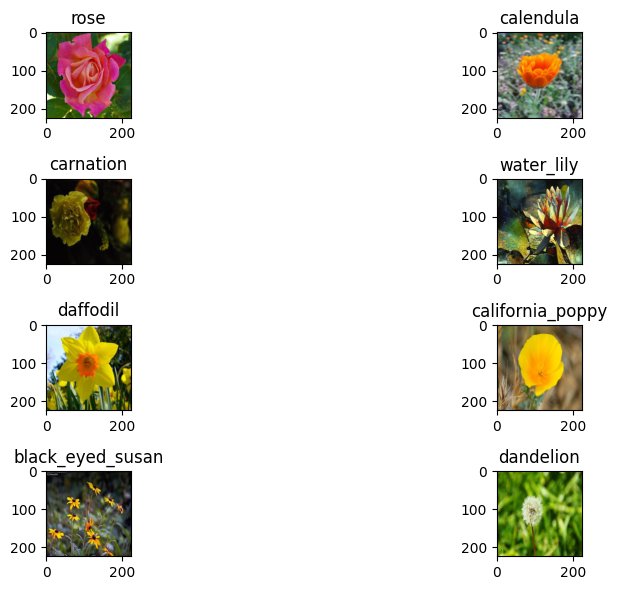

In [36]:
draw_images(image_list, top1_class_list)

In [37]:
len(image_list)

8

In [38]:
len(top1_class_list)

8